$$Model \ Inversion \  Attack - Face - ANN - Fredrikson$$

---



# Necessary Imports

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import Subset
import torch.nn.functional as F
from tqdm import tqdm
import os
from PIL import Image
import zipfile

**Read Me**

You may need to upload the following files through the code for more convenience:

- ***Face_ATnT_Data.zip***  : AT&T Faces Database raw files
- ***Face_ANN_Weights_Target*** : The pre-trained parameters for the target model
- ***Face_ANN_Weights_Eval*** : The pre-trained parameters for the evaluation classifier
- ***Face_ANN_Inverted*** : All the inverted samples extracted from the target model



# Data Preparation - AT&T Face Database

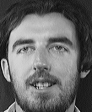

In [ ]:
zip_file_path= "/content/Face_ATnT_Data.zip"

# Extract the contents of the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall('/content/faces')  # Specify the directory to extract to

dataset_path = '/content/faces'  # Path to the extracted dataset folder

# Show a sample image
image = Image.open('/content/faces/s11/3.pgm')
image

In [ ]:
# Set the path to the dataset folder
dataset_path = '/content/faces'

# Define a transform
transform = transforms.Compose([
            transforms.Resize((112, 92)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))])

# Load the dataset using the ImageFolder class from torchvision
dataset = ImageFolder(dataset_path, transform=transform)

In [ ]:
# Number of persons (40 in the AT&T dataset)
num_persons = 40
indices = list(range(len(dataset)))

# Create a dictionary to store indices for each person
person_indices = {i: [] for i in range(num_persons)}

# Populate the dictionary with indices
for index in indices:
    person_id = index // 10  # Assuming 10 images per person
    person_indices[person_id].append(index)

# Initialize lists to store training and test indices
train_indices = []
test_indices = []

# Split each person's indices
for person_id, indices in person_indices.items():
    train_indices.extend(indices[:8])  # First 8 images for training
    test_indices.extend(indices[8:10])  # Last 2 images for testing

train_set = Subset(dataset, train_indices)
val_set = Subset(dataset, test_indices)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=8, shuffle=True , pin_memory=True)
test_loader = torch.utils.data.DataLoader(val_set, batch_size=8, shuffle=False)

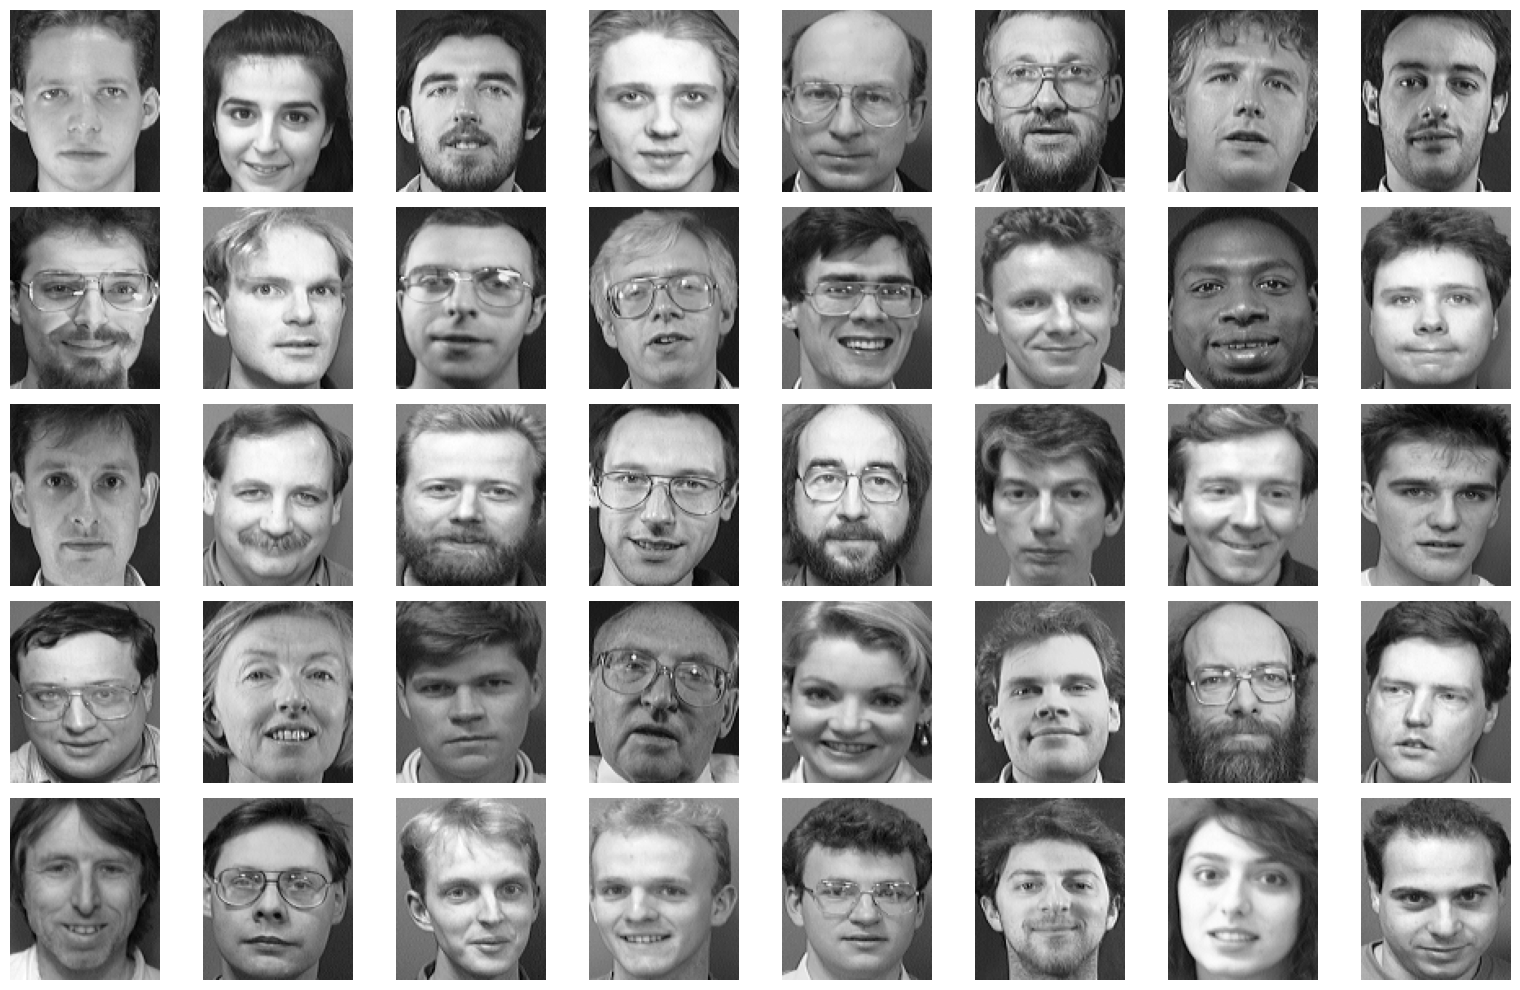

In [ ]:
# Ground Truth Images
fig, axes = plt.subplots(nrows=5, ncols=8, figsize=(16, 10))
plt.subplots_adjust(hspace=0.5)

for target_class in range(40):

    # Determine the subplot's position in the grid.
    row = target_class // 8
    col = target_class % 8

    # Display
    axes[row, col].imshow(dataset[target_class*10][0].squeeze(),cmap='gray')
    axes[row, col].axis('off')

# Adjust subplot layout and display the figure.
plt.tight_layout()
plt.show()


# Network Model and Training

In [ ]:
# Network Architecture Parameters
num_inputs= 112*92
num_hidden = 3000
num_outputs = 40

# Data Type and Device
dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [ ]:
# Define Network
class MLP_Net(nn.Module):
    def __init__(self):
        super(MLP_Net, self).__init__()

        # Initialize layers
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.fc2 = nn.Linear(num_hidden, num_outputs)

    def forward(self, x):

        x = x.view(x.size(0), -1)  # Flatten the input
        x = torch.sigmoid(self.fc1(x))
        x = self.fc2(x)
        return x

MLP = MLP_Net().to(device)

The state dictionary containing the pre-trained model's learned parameters is saved in **'Face_ANN_Weights_Target'** and can be loaded by running the following cell.

In [ ]:
# MLP.load_state_dict(torch.load("Face_ANN_Weights_Target",map_location=device))

<All keys matched successfully>

Following cell contains the training loop. If you have already loaded learned parameters, you don't need to run this cell.

In [ ]:
# MLP

# Define loss function (e.g., CrossEntropyLoss) and optimizer (e.g., Adam)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(MLP.parameters(), lr=5e-5, betas=(0.9, 0.999))



# Training loop
num_epochs = 70
for epoch in range(num_epochs):
    MLP.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = MLP(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / len(train_loader)}")

# Evaluation
MLP.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = MLP(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy}%")


with torch.no_grad():
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = MLP(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Train Accuracy: {accuracy}%")

Epoch 1/70, Loss: 3.866766119003296
Epoch 2/70, Loss: 3.4574359178543093
Epoch 3/70, Loss: 3.2072306752204893
Epoch 4/70, Loss: 2.9679351449012756
Epoch 5/70, Loss: 2.734792101383209
Epoch 6/70, Loss: 2.5144516587257386
Epoch 7/70, Loss: 2.3249475926160814
Epoch 8/70, Loss: 2.120525652170181
Epoch 9/70, Loss: 1.9775357782840728
Epoch 10/70, Loss: 1.8070223808288575
Epoch 11/70, Loss: 1.6523948818445207
Epoch 12/70, Loss: 1.5105359897017478
Epoch 13/70, Loss: 1.402955886721611
Epoch 14/70, Loss: 1.257789757847786
Epoch 15/70, Loss: 1.1589079305529595
Epoch 16/70, Loss: 1.0457753017544746
Epoch 17/70, Loss: 1.004121619462967
Epoch 18/70, Loss: 0.9033514201641083
Epoch 19/70, Loss: 0.8350335255265235
Epoch 20/70, Loss: 0.7625258982181549
Epoch 21/70, Loss: 0.721350409835577
Epoch 22/70, Loss: 0.6659380778670311
Epoch 23/70, Loss: 0.6212982855737209
Epoch 24/70, Loss: 0.5720942534506321
Epoch 25/70, Loss: 0.5195949129760266
Epoch 26/70, Loss: 0.4780529126524925
Epoch 27/70, Loss: 0.4531829

In [ ]:
# torch.save(MLP.state_dict(),"Face_ANN_Weights_Target")

# MI Attack

Reconstruction of one target classe:

Target Class:20


  2%|▏         | 107/5000 [00:14<10:49,  7.53it/s]


Terminating due to cost below threshold in iteration:  107

 Confidence Score:  0.9908416271209717


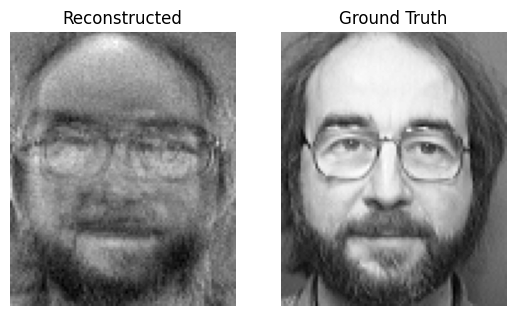

In [ ]:
# Initialize some variables
target = int(input('Target Class:')) # Specify your target class
MLP.to('cpu')
ini = torch.zeros((1, 112 * 92))  # Initialize ini with starting value

beta = 100  # Set the value of beta (the number of consecutive iterations without improvement)
consecutive_no_improvement = 0
gamma = 0.01  # Set the threshold value gamma
current_cost = float('inf')  # Initialize with positive infinity

for i in tqdm(range(5000)):
    ini.requires_grad_()

    cost = 1 - F.softmax(MLP(ini), dim=1)[0][target]

    # Compute the gradient
    cost.backward()

    with torch.no_grad():
        ini -= 0.1 * ini.grad

    # Check if cost has not improved for beta iterations
    if cost >= current_cost:
        consecutive_no_improvement += 1
    else:
        consecutive_no_improvement = 0

    if consecutive_no_improvement >= beta:
        print("Terminating due to no improvement for in iteration: ", i)
        break

    # Check if cost is below the threshold gamma
    if cost <= gamma:
        print("Terminating due to cost below threshold in iteration: ", i)
        break

    # Update the current_cost
    current_cost = cost

print("\n Confidence Score: ",F.softmax(MLP(ini), dim=1)[0][target].item())

fig,ax = plt.subplots(1,2)

ax[0].imshow(ini.view(112, 92).detach(), cmap='gray')
ax[0].set_title('Reconstructed')
ax[0].axis('off')

ax[1].imshow(dataset[target*10][0].squeeze(),cmap='gray')
ax[1].set_title('Ground Truth')
ax[1].axis('off')

plt.show()



**NOTE:** All of the inverted samples are stored in **"Face_ANN_Inverted"** and can be loaded by uncommenting the following command. Alternatively, they can be regenerated by running the next cell.

In [ ]:
# ini_tensors_MLP = torch.load('Face_ANN_Inverted',map_location=device)

Reconstruction of all classes:

In [ ]:
## FOR MLP

MLP.to('cpu')

ini_list = []  # List to save 'ini' tensors
cost_list = []  # List to save cost values


for target in range(40):


  ini = torch.zeros((1, 112 * 92))  # Initialize ini with starting value
  beta = 100  # Set the value of beta (the number of consecutive iterations without improvement)
  consecutive_no_improvement = 0
  gamma = 0.01  # Set the threshold value gamma
  current_cost = float('inf')  # Initialize with positive infinity

  for i in tqdm(range(5000)):
      ini.requires_grad_()

      cost = 1 - F.softmax(MLP(ini), dim=1)[0][target]

      # Compute the gradient
      cost.backward()

      with torch.no_grad():
          ini -= 0.1 * ini.grad

      # Check if cost has not improved for beta iterations
      if cost >= current_cost:
          consecutive_no_improvement += 1
      else:
          consecutive_no_improvement = 0

      if consecutive_no_improvement >= beta:
          print("Terminating due to no improvement for in iteration: ", i)
          break

      # Check if cost is below the threshold gamma
      if cost <= gamma:
          print("Terminating due to cost below threshold in iteration: ", i)
          break

      # Update the current_cost
      current_cost = cost


  # Save 'ini' tensor and cost value for this target
  ini_list.append(ini.detach().numpy())  # Convert to NumPy for saving
  cost_list.append(F.softmax(MLP(ini), dim=1)[0][target].item())
  print(cost)

# Convert the lists to tensors
ini_tensors_MLP = torch.tensor(ini_list)
cost_tensors_MLP = torch.tensor(cost_list)

  1%|          | 61/5000 [00:07<10:37,  7.74it/s]


Terminating due to cost below threshold in iteration:  61
tensor(0.0094, grad_fn=<RsubBackward1>)


  2%|▏         | 86/5000 [00:10<10:26,  7.84it/s]


Terminating due to cost below threshold in iteration:  86
tensor(0.0093, grad_fn=<RsubBackward1>)


  1%|▏         | 68/5000 [00:08<10:47,  7.62it/s]


Terminating due to cost below threshold in iteration:  68
tensor(0.0092, grad_fn=<RsubBackward1>)


  1%|▏         | 63/5000 [00:07<10:12,  8.07it/s]


Terminating due to cost below threshold in iteration:  63
tensor(0.0085, grad_fn=<RsubBackward1>)


  2%|▏         | 90/5000 [00:11<10:11,  8.03it/s]


Terminating due to cost below threshold in iteration:  90
tensor(0.0086, grad_fn=<RsubBackward1>)


  2%|▏         | 89/5000 [00:12<11:08,  7.34it/s]


Terminating due to cost below threshold in iteration:  89
tensor(0.0088, grad_fn=<RsubBackward1>)


  1%|          | 35/5000 [00:04<11:36,  7.13it/s]


Terminating due to cost below threshold in iteration:  35
tensor(0.0092, grad_fn=<RsubBackward1>)


  1%|          | 55/5000 [00:07<10:35,  7.78it/s]


Terminating due to cost below threshold in iteration:  55
tensor(0.0087, grad_fn=<RsubBackward1>)


  1%|          | 51/5000 [00:06<11:04,  7.45it/s]


Terminating due to cost below threshold in iteration:  51
tensor(0.0093, grad_fn=<RsubBackward1>)


  1%|▏         | 68/5000 [00:09<11:26,  7.18it/s]


Terminating due to cost below threshold in iteration:  68
tensor(0.0089, grad_fn=<RsubBackward1>)


  2%|▏         | 92/5000 [00:11<10:35,  7.72it/s]


Terminating due to cost below threshold in iteration:  92
tensor(0.0090, grad_fn=<RsubBackward1>)


  1%|▏         | 63/5000 [00:07<10:19,  7.96it/s]


Terminating due to cost below threshold in iteration:  63
tensor(0.0086, grad_fn=<RsubBackward1>)


  1%|▏         | 64/5000 [00:08<10:51,  7.58it/s]


Terminating due to cost below threshold in iteration:  64
tensor(0.0086, grad_fn=<RsubBackward1>)


  1%|          | 46/5000 [00:06<11:14,  7.34it/s]


Terminating due to cost below threshold in iteration:  46
tensor(0.0080, grad_fn=<RsubBackward1>)


  1%|          | 38/5000 [00:04<10:21,  7.98it/s]


Terminating due to cost below threshold in iteration:  38
tensor(0.0082, grad_fn=<RsubBackward1>)


  1%|          | 57/5000 [00:07<10:59,  7.50it/s]


Terminating due to cost below threshold in iteration:  57
tensor(0.0083, grad_fn=<RsubBackward1>)


  1%|          | 60/5000 [00:07<10:55,  7.54it/s]


Terminating due to cost below threshold in iteration:  60
tensor(0.0098, grad_fn=<RsubBackward1>)


  1%|          | 52/5000 [00:07<11:37,  7.10it/s]


Terminating due to cost below threshold in iteration:  52
tensor(0.0085, grad_fn=<RsubBackward1>)


  1%|          | 60/5000 [00:08<11:37,  7.08it/s]


Terminating due to cost below threshold in iteration:  60
tensor(0.0081, grad_fn=<RsubBackward1>)


  1%|▏         | 65/5000 [00:08<10:44,  7.66it/s]


Terminating due to cost below threshold in iteration:  65
tensor(0.0099, grad_fn=<RsubBackward1>)


  1%|          | 58/5000 [00:08<11:32,  7.13it/s]


Terminating due to cost below threshold in iteration:  58
tensor(0.0084, grad_fn=<RsubBackward1>)


  1%|          | 41/5000 [00:05<10:51,  7.61it/s]


Terminating due to cost below threshold in iteration:  41
tensor(0.0081, grad_fn=<RsubBackward1>)


  1%|          | 43/5000 [00:06<11:33,  7.15it/s]


Terminating due to cost below threshold in iteration:  43
tensor(0.0094, grad_fn=<RsubBackward1>)


  1%|▏         | 71/5000 [00:09<11:02,  7.44it/s]


Terminating due to cost below threshold in iteration:  71
tensor(0.0091, grad_fn=<RsubBackward1>)


  1%|          | 48/5000 [00:06<11:23,  7.25it/s]


Terminating due to cost below threshold in iteration:  48
tensor(0.0079, grad_fn=<RsubBackward1>)


  1%|▏         | 64/5000 [00:08<11:04,  7.42it/s]


Terminating due to cost below threshold in iteration:  64
tensor(0.0096, grad_fn=<RsubBackward1>)


  1%|▏         | 64/5000 [00:08<10:59,  7.48it/s]


Terminating due to cost below threshold in iteration:  64
tensor(0.0097, grad_fn=<RsubBackward1>)


  2%|▏         | 84/5000 [00:11<11:01,  7.44it/s]


Terminating due to cost below threshold in iteration:  84
tensor(0.0098, grad_fn=<RsubBackward1>)


  1%|          | 40/5000 [00:05<10:43,  7.71it/s]


Terminating due to cost below threshold in iteration:  40
tensor(0.0085, grad_fn=<RsubBackward1>)


  1%|          | 59/5000 [00:08<11:19,  7.28it/s]


Terminating due to cost below threshold in iteration:  59
tensor(0.0093, grad_fn=<RsubBackward1>)


  1%|▏         | 66/5000 [00:09<12:19,  6.67it/s]


Terminating due to cost below threshold in iteration:  66
tensor(0.0085, grad_fn=<RsubBackward1>)


  1%|▏         | 64/5000 [00:08<10:37,  7.75it/s]


Terminating due to cost below threshold in iteration:  64
tensor(0.0083, grad_fn=<RsubBackward1>)


  1%|          | 45/5000 [00:06<12:25,  6.65it/s]


Terminating due to cost below threshold in iteration:  45
tensor(0.0098, grad_fn=<RsubBackward1>)


  1%|          | 48/5000 [00:06<10:28,  7.88it/s]


Terminating due to cost below threshold in iteration:  48
tensor(0.0086, grad_fn=<RsubBackward1>)


  1%|          | 52/5000 [00:12<20:00,  4.12it/s]


Terminating due to cost below threshold in iteration:  52
tensor(0.0088, grad_fn=<RsubBackward1>)


  1%|          | 61/5000 [00:08<11:23,  7.23it/s]


Terminating due to cost below threshold in iteration:  61
tensor(0.0094, grad_fn=<RsubBackward1>)


  3%|▎         | 128/5000 [00:22<14:01,  5.79it/s]


Terminating due to cost below threshold in iteration:  128
tensor(0.0094, grad_fn=<RsubBackward1>)


  1%|▏         | 65/5000 [00:09<11:40,  7.05it/s]


Terminating due to cost below threshold in iteration:  65
tensor(0.0084, grad_fn=<RsubBackward1>)


  2%|▏         | 85/5000 [00:11<11:00,  7.45it/s]


Terminating due to cost below threshold in iteration:  85
tensor(0.0088, grad_fn=<RsubBackward1>)


  1%|▏         | 64/5000 [00:09<12:34,  6.54it/s]


Terminating due to cost below threshold in iteration:  64
tensor(0.0086, grad_fn=<RsubBackward1>)


In [ ]:
# torch.save(ini_tensors_MLP,'Face_ANN_Inverted')

# Attack Evaluation

## Visual Inspection

The inverted samples are stored in **"Face_ANN_Inverted"** and will be loaded at the first line of the following cell. Alternatively, they can be regenerated by running the previos section.

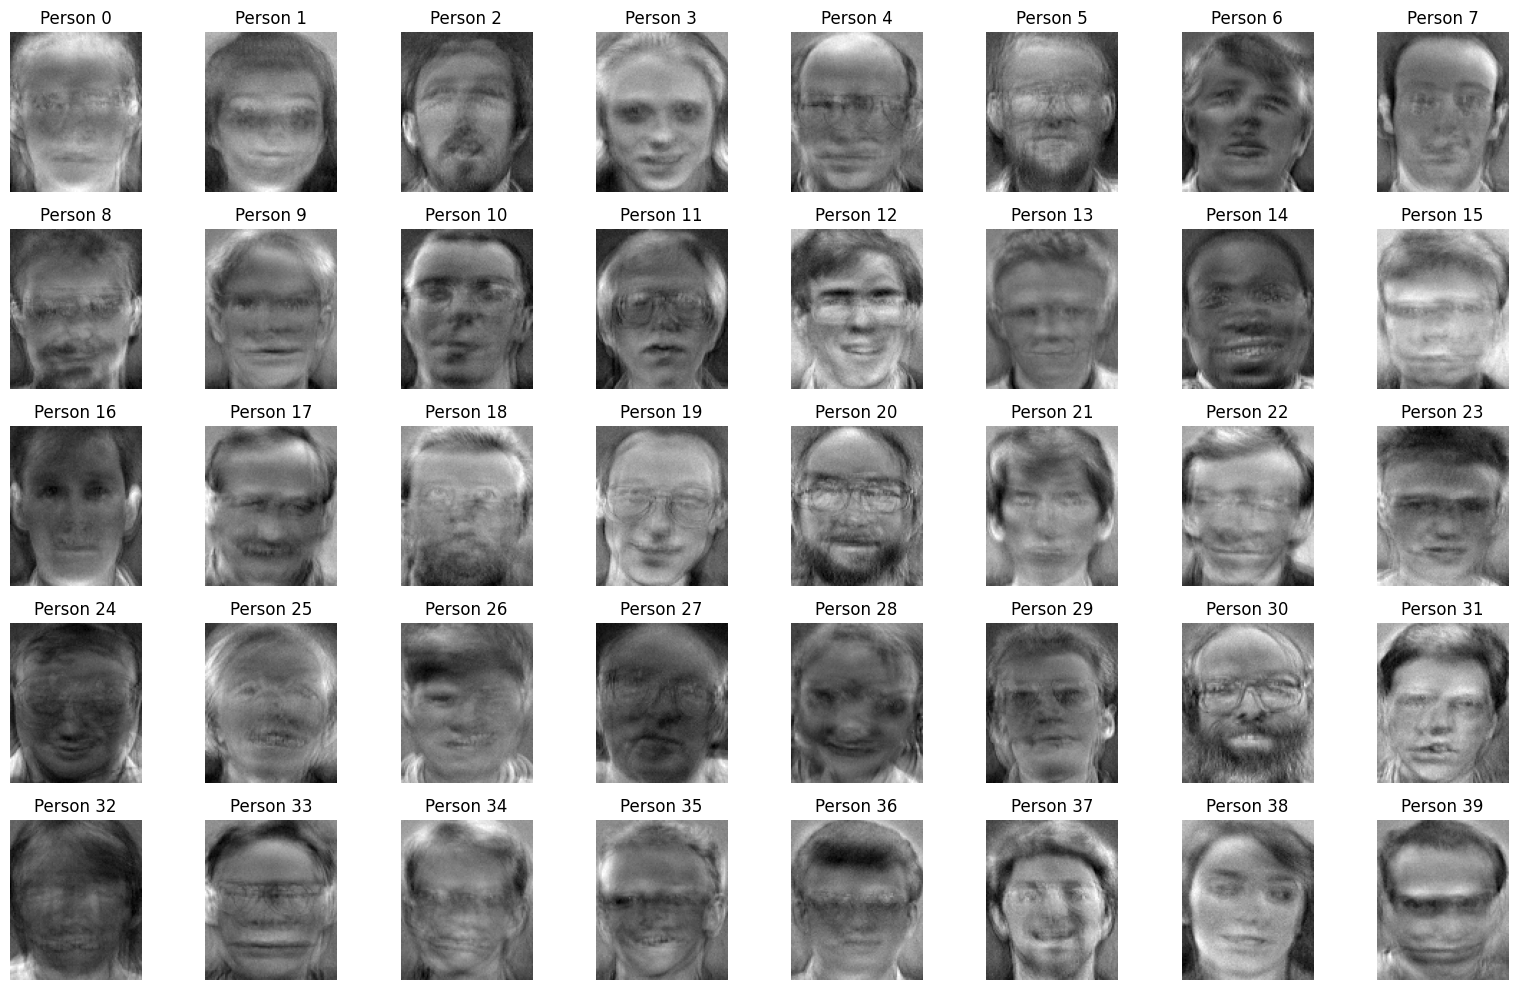

In [ ]:
ini_tensors_MLP = torch.load('Face_ANN_Inverted',map_location=device)

# Reshape the tensor to [40, 112, 92] assuming the images are 112x92 pixels
ini_tensors_reshaped = ini_tensors_MLP.view(40, 112, 92).cpu().numpy()

# Create a grid for plotting
fig, axes = plt.subplots(5, 8, figsize=(16, 10))  # 5 rows and 8 columns for 40 images

# Plot each image in the grid
for i in range(40):
    row, col = divmod(i, 8)  # Calculate the row and column index
    ax = axes[row, col]
    ax.imshow(ini_tensors_reshaped[i], cmap='gray')  # Assuming grayscale images
    ax.axis('off')  # Turn off axis labels
    ax.set_title(f'Person {i}')

# Adjust layout for better appearance
plt.tight_layout()

# Show the grid figure
plt.show()

## Evaluation Classifier

In [ ]:
# Define Network
class Eval_Net(nn.Module):
    def __init__(self):
        super(Eval_Net, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=12, kernel_size=5)  # 1 input channel (assuming grayscale image)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # Max pooling layer
        self.conv2 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=5)  # 12 input channels from previous layer

        # Fully connected layers
        self.fc1 = nn.Linear(24 * 25 * 20, 40)  # 24 channels, 25x20 image dimension after pooling
        self.relu = nn.ReLU()  # ReLU activation function

    def forward(self, x):
        # Apply convolutional and pooling layers
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))

        # Flatten the output for dense layers
        x = x.view(-1, 24 * 25 * 20)  # Flatten to 1D (24 channels, 25x20 image dimension after pooling)

        # Fully connected layers
        x = self.fc1(x)

        return x

eval_net = Eval_Net().to(device)
eval_net.parameters

<bound method Module.parameters of Eval_Net(
  (conv1): Conv2d(1, 12, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(12, 24, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=12000, out_features=40, bias=True)
  (relu): ReLU()
)>

The state dictionary containing the pre-trained model's learned parameters is saved in **'Face_ANN_Weights_Eval'** and can be loaded by running the following cell.

In [ ]:
eval_net.load_state_dict(torch.load("Face_ANN_Weights_Eval",map_location=device))

<All keys matched successfully>

Following cell contains the training loop. If you have already loaded learned parameters, you don't need to run this cell.

In [ ]:
# Define loss function (e.g., CrossEntropyLoss) and optimizer (e.g., Adam)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(eval_net.parameters(), lr=0.001)



# Training loop
num_epochs = 40
for epoch in range(num_epochs):
    eval_net.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = eval_net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / len(train_loader)}")

# Evaluation
eval_net.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = eval_net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy}%")


with torch.no_grad():
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = eval_net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Train Accuracy: {accuracy}%")

Epoch 1/40, Loss: 3.6716806650161744
Epoch 2/40, Loss: 2.424966123700142
Epoch 3/40, Loss: 0.6561379056423903
Epoch 4/40, Loss: 0.1891621142392978
Epoch 5/40, Loss: 0.13555463959928601
Epoch 6/40, Loss: 0.06423906835261732
Epoch 7/40, Loss: 0.010538892379554455
Epoch 8/40, Loss: 0.008929752009862568
Epoch 9/40, Loss: 0.0026920567084744106
Epoch 10/40, Loss: 0.0019974196431576273
Epoch 11/40, Loss: 0.0013734655374719295
Epoch 12/40, Loss: 0.0011505714159284254
Epoch 13/40, Loss: 0.0009370323910843581
Epoch 14/40, Loss: 0.0008623383058875333
Epoch 15/40, Loss: 0.000749242019810481
Epoch 16/40, Loss: 0.0006472119595855475
Epoch 17/40, Loss: 0.000565975196150248
Epoch 18/40, Loss: 0.0004998306752895587
Epoch 19/40, Loss: 0.00045611105360876536
Epoch 20/40, Loss: 0.00042310653880122117
Epoch 21/40, Loss: 0.00037211681683402276
Epoch 22/40, Loss: 0.00034093018221028617
Epoch 23/40, Loss: 0.0003147406108837458
Epoch 24/40, Loss: 0.0002881272685954173
Epoch 25/40, Loss: 0.00026294597155356313


In [ ]:
# torch.save(eval_net.state_dict(),'Face_ANN_Weights_Eval')

Here we define two useful functions for future use:

In [ ]:
# Function for calculating the accuracy and top-3 accuracy
def count_correct(lst):
    first = 0
    top_3 = 0

    for num in lst:
        # Count the number of occurrences of digit 1
        if num == 1:
          first += 1

        # Count the number of values between 2 and 3 (inclusive)
        if 2 <= num <= 3:
            top_3 += 1

    return first, top_3+first

# Function to scale a tensor values between 0 and 1
def Scale(x):
  return (x - x.min())/(x.max()-x.min())

The inverted samples are stored in **"Face_ANN_Inverted"** and will be loaded at the first line of the following cell. Alternatively, they can be regenerated by running the inversion attack section.

In [ ]:
ini_tensors_MLP = torch.load("Face_ANN_Inverted").view(40,1,112,92).to(device)
MLP.to(device) # Better safe than sorry!

MLP_Net(
  (fc1): Linear(in_features=10304, out_features=3000, bias=True)
  (fc2): Linear(in_features=3000, out_features=40, bias=True)
)

In [ ]:
# Scale the inputs
scaled_input = torch.zeros(40,1,112,92).to(device)
for i in range(40):
  scaled_input[i] = Scale(ini_tensors_MLP.view(40,1,112,92).to(device)[i])

# conf_mat = F.softmax(eval_net(ini_tensors_MLP.view(40,1,112,92).to(device)),dim=1).detach() # Confidence Matrix
conf_mat = F.softmax(eval_net(scaled_input),dim=1).detach() # Confidence Matrix
rank_mat = torch.argsort(conf_mat,descending=True) # Ranking Matrix
conf_ranks=[]

for i in range(40):
   conf_ranks.append(torch.where(rank_mat[i]==i)[0].item()+1)

DAA_ranks = conf_mat.argmax(0) # Out of all inverted samples, which one is the most similar to digit X


print("\n ** Predicted Labels  :\n\n",conf_mat.max(1)[1])
print("\n\n ** Predicted Labels Confidence  :\n\n",conf_mat.max(1)[0])

print("\n\n\n ** Ground Truth Ranks in Prediction  :\n\n",conf_ranks)
print("\n\n\n ** Number of corrects (First,Top-3)  :\n\n",count_correct(conf_ranks))

print("\n\n ** Confidences of the correct outputs  :\n\n",torch.diag(conf_mat))

print("\n\n ** DAA Ranks  :\n\n",DAA_ranks) # Out of all inverted samples, which one is the most similar to digit X


 ** Predicted Labels  :

 tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 27, 11, 12, 24, 14, 36, 16, 17,
        18, 19, 20, 36, 22, 23, 24, 25, 26, 27, 28, 29, 30, 36, 32, 33, 34, 35,
        36, 37, 38, 39], device='cuda:0')


 ** Predicted Labels Confidence  :

 tensor([1.0000, 0.9996, 0.9999, 0.9821, 1.0000, 1.0000, 0.9987, 1.0000, 0.5991,
        1.0000, 0.8053, 0.9999, 0.9384, 0.7917, 0.9952, 0.9999, 0.9990, 0.9939,
        1.0000, 0.9980, 1.0000, 0.9934, 0.9544, 0.9806, 0.9989, 1.0000, 1.0000,
        1.0000, 0.9767, 0.9967, 1.0000, 0.9613, 1.0000, 0.6491, 1.0000, 0.9097,
        0.9991, 0.9991, 0.9965, 0.9974], device='cuda:0')



 ** Ground Truth Ranks in Prediction  :

 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 3, 1, 6, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1]



 ** Number of corrects (First,Top-3)  :

 (35, 39)


 ** Confidences of the correct outputs  :

 tensor([1.0000e+00, 9.9965e-01, 9.9987e-01, 9.8209e-01, 9.9998e-01, 9.9999e-01,
        

In [ ]:
print("Attack Accracy:",count_correct(conf_ranks)[0]/40)
print("\n\nTop-3 Attack Accuracy:", count_correct(conf_ranks)[1]/40)
print("\n\n ** Average Confidence of correct outputs",torch.diag(conf_mat).mean().item())
print("\n\nDAA:", (sum(DAA_ranks==torch.tensor(range(40)).to(device)).item())/40)

Attack Accracy: 0.875


Top-3 Attack Accuracy: 0.975


 ** Average Confidence of correct outputs 0.8550677299499512


DAA: 0.95
